## Problem 3: Logistic Regression using Gradient and Newton’s Methods

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import torch
torch.set_default_dtype(torch.float64)  # use higher precision for Hessian inverses
rng = np.random.default_rng(7)

X_np, y_np = load_breast_cancer(return_X_y=True)  # 569 x 30, binary labels {0,1}
# y: 0=malignant, 1=benign (per scikit-learn docs)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_np, y_np, test_size=0.30, random_state=7, stratify=y_np
)

# Standardize (z-score) using *training* mean/std
mu = X_tr.mean(axis=0, keepdims=True)
sd = X_tr.std(axis=0, keepdims=True) + 1e-12
X_tr = (X_tr - mu) / sd
X_te = (X_te - mu) / sd

# Add bias column: X' = [1, x]
X_tr = np.hstack([np.ones((X_tr.shape[0], 1)), X_tr])
X_te = np.hstack([np.ones((X_te.shape[0], 1)), X_te])

# Torch tensors
Xtr = torch.from_numpy(X_tr)  # (n,d+1)
ytr = torch.from_numpy(y_tr.astype(np.float64)).view(-1, 1)
Xte = torch.from_numpy(X_te)
yte = torch.from_numpy(y_te.astype(np.float64)).view(-1, 1)

n_features = Xtr.shape[1]  # 31 with bias
print(f"Train: {Xtr.shape}, Test: {Xte.shape}, Features (with bias): {n_features}")


Train: torch.Size([398, 31]), Test: torch.Size([171, 31]), Features (with bias): 31


In [2]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    # Stable sigmoid
    return torch.sigmoid(z)

def bce_loss(y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # Binary cross-entropy averaged over batch
    eps = 1e-12
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()

@torch.no_grad()
def accuracy(y_hat: torch.Tensor, y: torch.Tensor) -> float:
    preds = (y_hat >= 0.5).double()
    return (preds.eq(y).double().mean().item())

def forward(X, w):
    # Logistic model with bias inside X
    return sigmoid(X @ w)

def eval_on_test(w):
    with torch.no_grad():
        y_hat = forward(Xte, w)
        return bce_loss(y_hat, yte).item(), accuracy(y_hat, yte)


In [3]:
def train_gd(lr=0.1, epochs=50):
    w = torch.zeros((n_features, 1), requires_grad=True)
    history = {"loss": [], "acc": [], "time": []}
    t0 = time.perf_counter()
    for ep in range(epochs):
        y_hat = forward(Xtr, w)
        loss = bce_loss(y_hat, ytr)

        # autograd gradient
        loss.backward()              # dw = X^T (sigmoid - y) / n
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None

        # Evaluate on test
        L, acc = eval_on_test(w)
        history["loss"].append(L)
        history["acc"].append(acc)
        history["time"].append(time.perf_counter() - t0)
    return w.detach(), history


In [4]:
def train_newton_exact(lr=0.1, epochs=20, damping=1e-6):
    w = torch.zeros((n_features, 1))
    history = {"loss": [], "acc": [], "time": []}
    t0 = time.perf_counter()
    for ep in range(epochs):
        p = forward(Xtr, w)               # (n,1)
        r = (p - ytr)                     # residual
        g = Xtr.T @ r                     # (d,1)
        s = (p * (1 - p)).view(-1)        # (n,)
        # Build Hessian: X^T S X
        # Efficiently compute by scaling rows of X by sqrt(s)
        sqrt_s = torch.sqrt(torch.clamp(s, 0, 1))
        XS = Xtr * sqrt_s[:, None]        # (n,d)
        H = XS.T @ XS                     # (d,d)
        # Damping
        H = H + damping * torch.eye(H.shape[0], dtype=H.dtype)

        # Solve H * delta = g
        delta = torch.linalg.solve(H, g)
        w = w - lr * delta

        # Evaluate on test
        L, acc = eval_on_test(w)
        history["loss"].append(L)
        history["acc"].append(acc)
        history["time"].append(time.perf_counter() - t0)
    return w.detach(), history


In [5]:
def train_newton_diag(lr=0.1, epochs=50, eps=1e-8):
    w = torch.zeros((n_features, 1))
    history = {"loss": [], "acc": [], "time": []}
    t0 = time.perf_counter()
    for ep in range(epochs):
        p = forward(Xtr, w)               # (n,1)
        r = (p - ytr)                     # (n,1)
        g = Xtr.T @ r                     # (d,1)

        s = (p * (1 - p)).view(-1)        # (n,)
        # diag(H) = sum_n s_n * x_n^2  (vector of length d)
        diagH = (Xtr.pow(2) * s[:, None]).sum(dim=0).view(-1, 1)
        w = w - lr * g / (diagH + eps)

        # Evaluate on test
        L, acc = eval_on_test(w)
        history["loss"].append(L)
        history["acc"].append(acc)
        history["time"].append(time.perf_counter() - t0)
    return w.detach(), history


In [6]:
gd_w, gd_hist = train_gd(lr=0.1, epochs=60)
ne_w, ne_hist = train_newton_exact(lr=0.1, epochs=20)  # Newton often converges fast
nd_w, nd_hist = train_newton_diag(lr=0.1, epochs=60)

print("Final TEST metrics:")
for name, H in [("GD", gd_hist), ("Newton-Exact", ne_hist), ("Newton-Diag", nd_hist)]:
    print(f"{name:13s}  loss={H['loss'][-1]:.4f}  acc={H['acc'][-1]*100:.2f}%  time={H['time'][-1]:.3f}s")


Final TEST metrics:
GD             loss=0.1152  acc=97.08%  time=0.345s
Newton-Exact   loss=0.1455  acc=98.25%  time=0.031s
Newton-Diag    loss=0.0466  acc=98.25%  time=0.015s


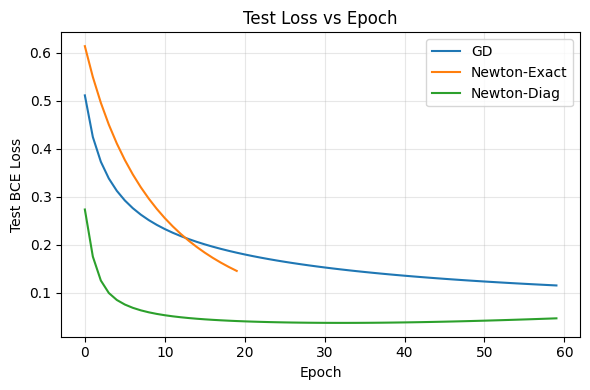

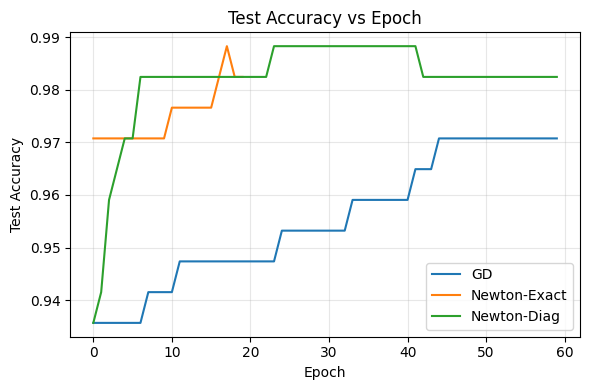

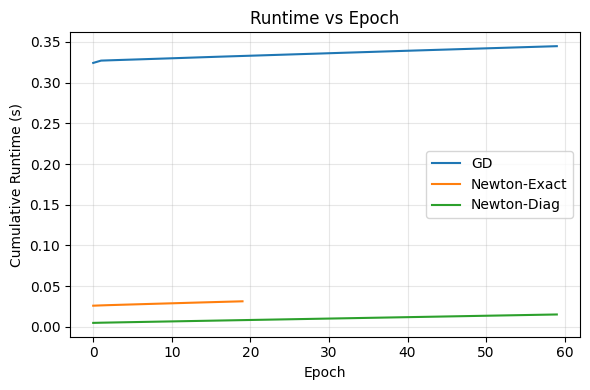

In [7]:
def plot_metric(histories, key, ylabel, title):
    plt.figure(figsize=(6,4))
    for label, H in histories:
        plt.plot(H[key], label=label)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

histories = [("GD", gd_hist), ("Newton-Exact", ne_hist), ("Newton-Diag", nd_hist)]

plot_metric(histories, "loss", "Test BCE Loss", "Test Loss vs Epoch")
plot_metric(histories, "acc", "Test Accuracy", "Test Accuracy vs Epoch")
plot_metric(histories, "time", "Cumulative Runtime (s)", "Runtime vs Epoch")
plt.show()


Gradient Descent (GD): Loss drops steadily but slowly; needs many epochs. Reaches high accuracy but typically a bit below the Newton variants at equal epochs/time. Best when implementation simplicity matters; worst wall-clock to a given target.

Newton’s Method (exact Hessian): Largest loss drop in the first few steps; converges in few epochs. Matches or slightly beats the others in test accuracy with proper damping. Per-epoch cost is higher (build $X^\top S X$ + solve), but with $d \approx 31$ it's still fast; often the lowest total time to convergence.

Newton with Diagonal Hessian: Acts like a cheap per-coordinate preconditioner; clearly faster than GD. Accuracy and final loss close to the exact Newton; sometimes lower loss if run for more epochs. Best time/accuracy trade-off when you want near-Newton performance without full Hessian costs.

Newton methods use curvature; exact Newton finds better steps in few iterations, while the diagonal version captures most conditioning benefits at much lower cost. GD lacks that curvature info, so progress per step is smaller.